In [1]:
import sys
import os
mp = os.path.abspath(os.path.join('/content/drive/My Drive/GraduationThesis/gitrepo/GraduationThesis/'))
sys.path.append(mp)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from modules import Rbf
import math

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def read_txt2(filename, device):
  onsurface_points = np.zeros((0,2))
  shifted_points = np.zeros((0,2)) # onsurface_points left shifted by 1
  first_point = np.zeros((1,2))
  last_point = np.zeros((1,2))

  with open(filename, 'r') as f:
    for c in range(int(f.readline())):
      num_of_verticles = int(f.readline())

      first_point[0] = np.loadtxt(f, max_rows=1)
      middle_points = np.loadtxt(f, max_rows=num_of_verticles-2)
      last_point[0] = np.loadtxt(f, max_rows=1)

      # Onsuface points order: first_point,middle_points,last_point
      # Shifted points order:  middle_points,last_point,first_point
      onsurface_points = np.concatenate((onsurface_points, first_point))    # Onsurface: first_point
      onsurface_points = np.concatenate((onsurface_points, middle_points))  # Onsurface: middle_points
      shifted_points = np.concatenate((shifted_points, middle_points))      # Shifted: middle_points
      # Remove the last point if it is the same as the first point
      if np.not_equal(last_point,first_point).any():
        onsurface_points = np.concatenate((onsurface_points,last_point))    # Onsurface: last_point
        shifted_points = np.concatenate((shifted_points,last_point))        # Shifted: last_point
      shifted_points = np.concatenate((shifted_points,first_point))         # Shifted: first_point

  # Vector of 2 consecutive points
  vectors = shifted_points - onsurface_points
  # Getting normal vectors
  norm = np.linalg.norm(vectors, axis=1)
  normal_vectors = np.ones_like(vectors)

  normal_vectors[:,0] = np.divide(-vectors[:,1],norm)
  normal_vectors[:,1] = np.divide(vectors[:,0],norm)

  d = torch.from_numpy(onsurface_points).float().to(device)
  d.requires_grad = True
  n = torch.from_numpy(normal_vectors).float().to(device)
  n.requires_grad = True

  return d,n

In [5]:
# Off surface points
filename = mp + '/dataset/2d/riderr.vert'
dataset, normal_vectors = read_txt2(filename, device)
# dataset, mormal_vectors = dataset.to(device), normal_vectors.to(device)
# dataset = dataset.to(device)
# dataset.requires_grad = True
# print(dataset)

In [6]:
# Grid
def dist_grid(X, Y):
  xmin = torch.min(X).item()
  xmax = torch.max(X).item()
  ymin = torch.min(Y).item()
  ymax = torch.max(Y).item()

  # print(xmax)
  # print(xmax.item())

  dx = xmax - xmin
  dy = ymax - ymin

  resx = 50
  resy = 50

  ed = 0.1*math.sqrt(dx*dx+dy*dy)

  x = torch.arange(xmin-ed, xmax+ed, step=(dx+2*ed)/float(resx))
  y = torch.arange(ymin-ed, ymax+ed, step=(dy+2*ed)/float(resy))

  return torch.meshgrid(x, y)

In [7]:
dist_x, dist_y = dist_grid(dataset[:,0], dataset[:,1])
dist_x, dist_y = dist_x.to(device), dist_y.to(device)
dist = torch.stack((dist_x, dist_y), axis=2)
# dist = dist.to(device)
dist.requires_grad = True

In [8]:
class IGRPerceptron(nn.Module):
  def __init__(self):
    super(IGRPerceptron, self).__init__()
    self.fc1 = nn.Linear(2, 512)
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, 512)
    self.fc4 = nn.Linear(512, 512)
    self.fc5 = nn.Linear(512, 512)
    self.fc_last = nn.Linear(512, 1)
    self.activation = nn.Softplus()

  def forward(self, x):
    out = self.fc1(x)
    # out = torch.flatten(out, 1)
    out = self.activation(out)
    out = self.fc2(out)
    out = self.activation(out)
    out = self.fc3(out)
    out = self.activation(out)
    out = self.fc4(out)
    out = self.activation(out)
    out = self.fc5(out)
    out = self.activation(out)
    out = self.fc_last(out)
    return out

In [9]:
def eikonal(nn, distribution):
  out = nn(distribution).sum().backward()
  # out = out.backward()
  # print(distribution.grad)
  # print(out)
  # print(nn(distribution).sum())
  # print(distribution.grad)
  return distribution.grad

In [10]:
# loss = \sum_I (w^T*x_i)^2 + 0.1 * (||w||^2 - 1)^2
def irg_loss(nn, input, distribution):
  # print(nn.device)
  # print(eikonal(nn, distribution))
  # w^T*x_1 = w_x1 * x_1 + w_y1 * y_1 + w_x2 * x_1 + w_y2 * y_1 + ... + w_xn * x_1 + w_yn * y_1
  # return torch.sum(torch.square(torch.sum(torch.sum(w*x[:,None], dim=1), dim=1))) + 0.1*torch.square(torch.square(torch.norm(w)-1))

  # w^t * x_1 = w_1 * x_1 + w_2 * x_1 + ... + w_n * x_1 
  # d = torch.sqrt(torch.sum(torch.square(x - x[:, None]), dim=2)) #pdist squareform
  # return torch.sum(torch.square(torch.sum(w*d, dim=0))) + 0.1*torch.square(torch.square(torch.norm(w)-1))
  loss = torch.mean(torch.abs(nn(input))) + 0.1*(torch.norm(eikonal(nn, distribution)) -1)**2
  return loss

In [11]:
# loss = irg_loss(my_nn, dataset, dist)

In [12]:
my_nn = IGRPerceptron()
# if not next(my_nn.parameters()).is_cuda:
my_nn = my_nn.to(device)
# next(my_nn.parameters()).to(device)
optimizer = torch.optim.Adam(my_nn.parameters())

for i in range(5000): 
  my_nn(dataset)
  loss = irg_loss(my_nn, dataset, dist)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

print(loss)
# print(result)

tensor(3.6093, device='cuda:0', grad_fn=<AddBackward0>)


In [13]:
def sampling(nn, xx, yy):
  # dimg = xx.shape
  # z = torch.zeros(dimg)
  z = torch.empty((0,1))
  print(z.shape)
  # g = np.concatenate((xx, yy), axis=1)
  # print(xx.shape)
  # t = w[None, 0] * xx
  # print(t)
  tt = torch.stack((xx, yy), axis=2)
  tt = torch.reshape(tt, (2500,2))
  # print(tt)
  # print(tt.shape)
  # print(tt)
  # print(tt)
  # for k in range(int(dimw[0])):
  #   z += w[k] * np.sqrt((xx - x[k,0])**2 + (yy - x[k,1])**2)
    # z += np.sqrt(np.square(w[i] * (xx-dataset) + np.square(w[i] * yy))
    # z += np.square(w[i,0] * (xx-dataset.numpy()[i,0]) + w[i,1]*(yy-dataset.numpy()[i,1]))
  # z = np.square(w[:,0]*xx[:] + w[:,1]*yy[:])
  # z = np.sum(np.sum(np.square(w*g[:, None]), axis=1), axis=1)
  # print(t.shape)

  # i = 0
  # while True:
  #   if (i+200>=len(tt)):
  #     out = nn(tt[i:len(tt), :])
  #     z = torch.cat((z,out))
  #     break

  #   out = nn(tt[i:i+200, :])
  #   z = torch.cat((z,out))
  #   i = i+200

  z = nn(tt)
  # print(z)
  # print(z.shape)
  print(torch.reshape(z, (50,50)))

  return torch.reshape(z, (50,50))

In [14]:
# xx,yy = Rbf.grid(dataset[:,0].numpy(), dataset[:,1].numpy())
# z = sampling(result.detach().numpy(), xx ,yy)
# z = sampling(dataset.numpy(), result.detach().numpy(), xx, yy)
z = sampling(my_nn, dist_x, dist_y)

torch.Size([0, 1])
tensor([[-0.0308, -0.0308, -0.0308,  ..., -0.0308, -0.0308, -0.0308],
        [-0.0308, -0.0308, -0.0308,  ..., -0.0308, -0.0308, -0.0308],
        [-0.0308, -0.0308, -0.0308,  ..., -0.0308, -0.0308, -0.0308],
        ...,
        [-0.0308, -0.0308, -0.0308,  ..., -0.0308, -0.0308, -0.0308],
        [-0.0308, -0.0308, -0.0308,  ..., -0.0308, -0.0308, -0.0308],
        [-0.0308, -0.0308, -0.0308,  ..., -0.0308, -0.0308, -0.0308]],
       device='cuda:0', grad_fn=<ViewBackward>)


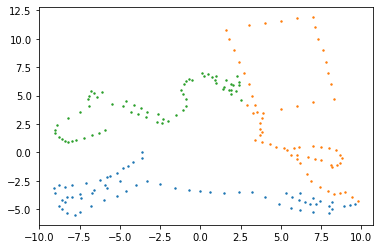

/content/drive/My Drive/GraduationThesis/gitrepo/GraduationThesis/modules/Rbf.py:149: UserWarning: No contour levels were found within the data range.
  h_object = plt.contour(xx,yy, z, levels=[0.0], colors='c')


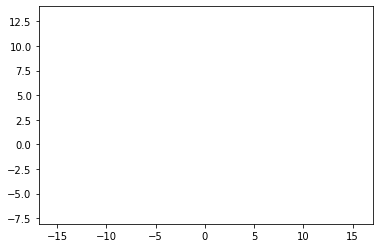

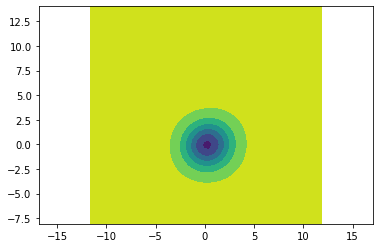

In [15]:
Rbf.visualize2(dataset.detach().cpu().numpy(), normal_vectors.detach().cpu().numpy(), dist_x.detach().cpu().numpy(), dist_y.detach().cpu().numpy(), z.detach().cpu().numpy(), scatter=True, vecfield=False, surface=True, offsurface=False, filled_contour=True)

In [16]:
# x = torch.tensor([[5, 3], [2, 1], [3,2]], dtype=torch.float)
# y = torch.tensor([[1,1], [1,2], [3,2]], dtype=torch.float)

# x = x.numpy()
# y = y.numpy()

# t = np.concatenate((x,y), axis = 1)

# # t = torch.matmul(torch.transpose(x, 0, 1),y)
# # t = torch.matmul(x[:, :], y[:,:)])
# # t = x * y [:, None]
# # t = torch.cat((x,y), dim=1)
# # t = t.numpy()
# # t = np.sum(t, axis=1)
# # t = np.sum(t, axis=1)

# print(t)

In [17]:
# x = torch.tensor([[5, 3], [2, 1], [3,2]], dtype=torch.float)
# y = torch.tensor([[1,1], [1,2], [2,3]], dtype=torch.float)
# w = torch.tensor([[5], [2], [1]], dtype=torch.float)

# # t = np.concatenate((x,y), axis = 1)

# # t = torch.matmul(torch.transpose(x, 0, 1),y)
# # t = torch.matmul(x[:, :], y[:,:)])
# t = x - y [:, None]
# # t = torch.cat((x,y), dim=1)
# # t = t.numpy()
# t = torch.sum(t, dim=2)
# # t = w*t
# # t = torch.sum(t, dim=0)

# print(t)

In [18]:
# x = torch.tensor([[5], [2], [1], [3],[2]], dtype=torch.float)
# y = torch.tensor([1, 2, 3, 4], dtype=torch.float)

# # t = x[None, :] * y[:, None]
# t = x * y
# t = torch.sum(t, dim=0)
# print(t)